### **Project work in Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**

```Stefano Poggi Cavalletti```

## **Classification of ECG signals**

The aim of this project is to perform a classification task on health data related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use an available dataset which contains ECG data of real patients: ECG5000. We will perform data analysis and then we will define and train different deep learning models for classification: CNN, LSTM and their combination using Keras library.

The [ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series with 140 timesteps. Each sequence corresponds to a single heartbeat extracted from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. In general, the frequency is 60-100 beat per minute and the duration of each heartbeat is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'

train_data = pd.read_csv(ecg_test_file)
test_data = pd.read_csv(ecg_train_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [ ]:
def process_df(df):
  ''' Pre-processes the DataFrame and returns
  the updated one'''

  new_columns = list(df.columns)
  new_columns[0] = 'target'
  df.columns = new_columns
  df['target'] = df[df.columns[-1]]
  del df[df.columns[-1]]
  
  return df

In [ ]:
df_train = process_df(df_train)
df_test = process_df(df_test)

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df

,target,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140
0,1,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,...,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073
1,1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,...,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009
2,1,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,...,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767
3,1,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,...,0.894638,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853
4,1,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,...,1.416582,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4,-0.478577,-1.779959,-2.398159,-3.170112,-3.559732,-3.573956,-2.989770,-2.270605,-1.688277,...,1.294840,1.160885,1.456331,2.209421,2.507175,2.198534,1.705849,1.492642,1.561890,1.520161
4996,4,-1.325210,-2.480992,-2.965356,-3.342392,-3.176351,-2.891528,-2.369679,-1.598750,-1.071751,...,0.552076,-0.172154,-0.864803,-1.549854,-2.460243,-3.366562,-3.466546,-2.718380,-1.855209,-1.539958
4997,4,-0.021964,-0.912434,-1.903353,-2.662829,-3.122156,-3.451490,-3.392982,-2.929937,-2.256294,...,1.528745,1.339479,1.457995,2.128078,2.630759,2.295748,1.764967,1.444280,1.432347,1.457028
4998,5,0.288011,-1.098020,-2.500250,-3.598599,-3.650608,-3.281587,-2.231601,-1.250656,-1.072574,...,0.081634,-0.029242,0.071414,0.118161,-0.071967,-0.171214,0.131211,0.049872,0.010915,-0.081534


We show some statistics about data

In [ ]:
df.describe()

,target,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t131,t132,t133,t134,t135,t136,t137,t138,t139,t140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,...,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,...,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,...,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,...,-0.655753,-1.089300,-1.588885,-2.147449,-2.731550,-3.030509,-2.868331,-2.153513,-1.657771,-1.596692
50%,1.000000,-0.297541,-1.661892,-2.585677,-3.387934,-3.468718,-2.947061,-2.285578,-1.750157,-1.422570,...,0.473642,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.565588
75%,2.000000,0.500061,-0.677290,-1.513964,-2.235369,-2.530967,-2.398813,-1.823494,-1.484923,-1.063708,...,1.062134,1.169420,1.238687,1.264471,1.234433,1.034584,0.945237,0.951681,1.002692,0.272012
max,5.000000,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,...,2.960969,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103


What can be seen is that the min and max values are between the range [-7, 7], while the mean value is more or less in range between [-1,1].

There is a total of 5000 examples, where each row represents a single heartbeat record. There are five values from 1 to 5 in the 'target' column, representing the five possible classes available. We will now name the different classes to perform some data analysis.

In [ ]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [ ]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

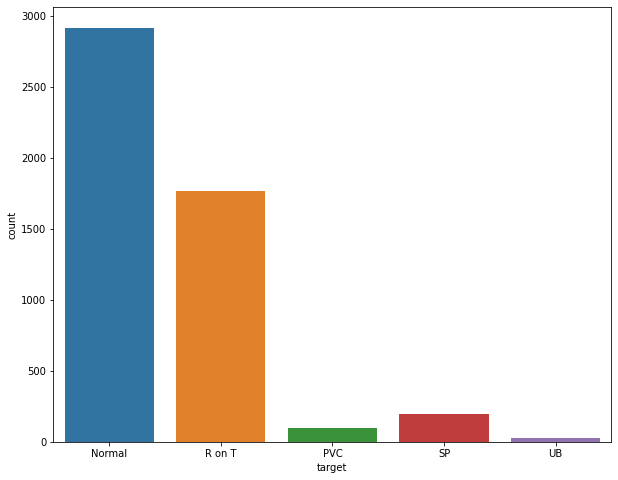

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

As we can see, classes are very unbalanced, with normal class being the most common with 2919 sequences, followed by the class with label R-on-T PVC. However, this might turn out useful to train our model. Moreover, if we sum all the remaining abnormal sequences we get a total value of 2081, which gets closer to the amount of normal sequences.

### Handling imbalanced datasets

Since the dataset suffers from a high class imbalance, this problem could
bring a strong bias to the model. A solution consists in performing a resampling of the dataset. Resampling is a way to balance the class distribution in the dataset, both by generating new samples of minority classes
(oversampling) and by discarding samples of the majority class (undersampling). **Synthetic Minority Oversampling TEchnique (SMOTE)** was used to make oversampling of the minority classes (R on T, PVC, SP, UB), combined with Tomek links, obtaining the SMOTE-Tomek ensemble method. In particular, SMOTE oversamples the minority classes: it generates synthetic data points by considering the nearest neighbors of the minority class data points, while Tomek links remove samples from the majority class to clean the class boundary and increase the inter-class separability.

We now define a function which will apply an under/over-sampling method to our data. It returns arrays of new samples and their labels.

In [ ]:
def over_under_sampling(dataframe):
    """
    Over-samples and under-samples an imbalanced dataset using the SMOTETomek technique.

    The function takes a Pandas dataframe as input, where each row is a sample with a corresponding target label. 
    The function creates synthetic samples for the minority classes using the SMOTETomek algorithm, and removes any instances 
    that are identified as noisy or ambiguous by the Tomek links technique.
    """

    # Initialize empty lists to store the new feature and label values after over-under sampling.
    X_res = []
    y_res = []

    # Loop over each underrepresented class (class 2-5).
    for i in range(2,6):
        
        # Create a copy of the input dataframe.
        df_copy = dataframe.copy()
        
        # Select only the rows with target label equal to the current class.
        df = df_copy[df_copy['target'] == i]
        
        # Append rows from the dominant class (class 1) to create a new dataframe.
        df = df.append(df_copy[df_copy['target'] == 1])
        
        # Split the dataframe into features (X) and labels (y).
        X = df.values[:,1:]
        y = df.values[:,0]

        # Apply the SMOTETomek algorithm to over-under sample the data.
        smtomek = SMOTETomek(random_state=RANDOM_SEED)
        X_r, y_r = smtomek.fit_resample(X, y)
        
        # Skip the data that was fit on and append the remaining data to the output lists.
        skip = y.shape[0]
        X_res.append(X_r[skip:,:])
        y_res.append(y_r[skip:])

    # Concatenate the feature and label values into two numpy arrays and return them.
    X_res = np.concatenate(X_res)
    y_res = np.concatenate(y_res)
    
    return X_res, y_res

In [ ]:
X_os, y_os = over_under_sampling(df_train)

### Split the dataframe into data and labels

We now separate the data from the labels and create X_train, X_test, y_train, y_test.

In [ ]:
X_train = df_train.values[:,1:]  
y_train = df_train.values[:,0]  

X_test = df_test.values[:,1:] 
y_test = df_test.values[:,0]

In [ ]:
X_train = np.concatenate((X_train, X_os))
y_train = np.concatenate((y_train, y_os))

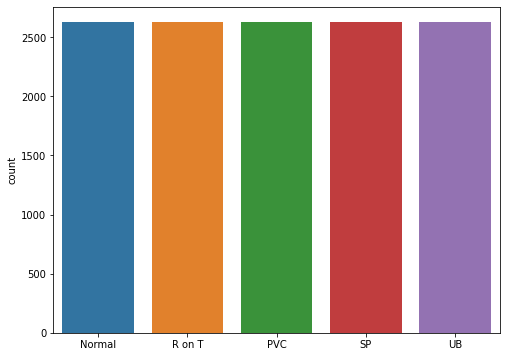

In [ ]:
plt.figure(figsize=(8,6))

ax = sns.countplot(x=y_train)
ax.set_xticklabels(class_names);


We have dealt dataset imbalance, now we want to check how the new synthetic data looks like and if it is somewhat similar to the original data.

### Visualizing the signals

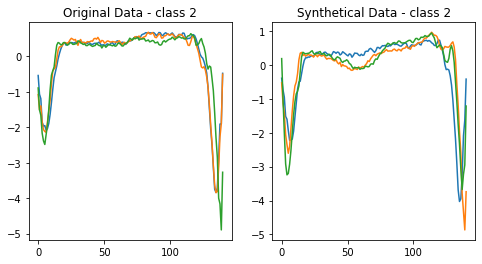

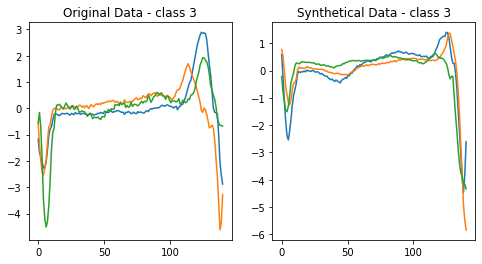

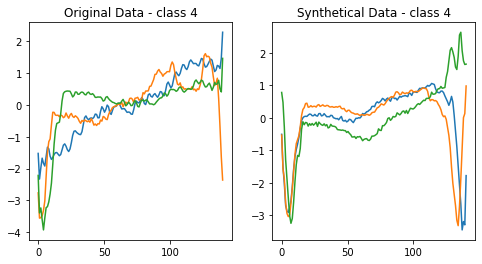

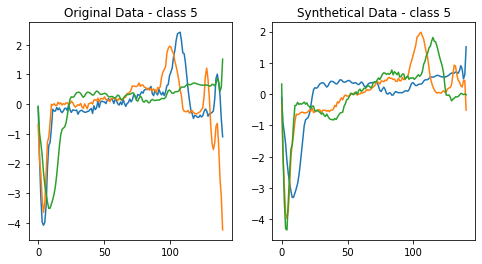

In [ ]:
# visualizing signals (original vs synthetical) for all classes

t = np.linspace(0, 140, 140)

for i in range(2,6):
    id = np.where(y_train == i)[0][:3]
    id_os = np.where(y_os == i)[0][:3]

    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1) 
    plt.plot(t, X_train[id[0]], t, X_train[id[1]], t, X_train[id[2]])
    plt.title('Original Data - class ' + str(i))
    
    plt.subplot(1, 2, 2) 
    plt.plot(t, X_os[id_os[0]], t, X_os[id_os[1]], t, X_os[id_os[2]])
    plt.title('Synthetical Data - class ' + str(i))

### Data preprocessing

As normalization pre-processing technique, we apply MinMax scaler to the input signals in order to scale and translate them into a [0, 1] range.

In [ ]:
scaler = preprocessing.MinMaxScaler()
data_scaler = scaler.fit(X_train)

In [ ]:
X_train = data_scaler.transform(X_train)
X_test = data_scaler.transform(X_test)

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
# we index classes from 0 to 4
y_train = y_train - 1            
y_test = y_test - 1

We now create a validation set by taking 20% of training data.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=RANDOM_SEED)

We define some functions for plotting accuracy, loss and confusion matrix

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    return plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    return plt.show()

def plot_confusion_matrix(model, x_test):
    y_predict = model.predict(x_test)
    y_pred = []

    for i in range(len(y_predict)):
        y_pred.append(np.argmax(y_predict[i,:]))

    cm = confusion_matrix(y_test, y_pred)
    # Normalize
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")

    return plt.show()
     

### Model 1: Conv1D

The first model is a 1D Convolutional Neural Network (CNN) model, which has an input layer with a shape of (140,1), since we have data with 140 timesteps and one feature (140x1 array). The model consists of two Conv1D layers, followed by two MaxPool1D layers. The output from the Conv1D and MaxPool1D layers is then flattened using the Flatten layer. Then there is a Dense layer and a Dropout layer to prevent overfitting. The final layer is a Dense output layer with 5 neurons (since we have 5 different classes) and a Softmax activation function.

Moreover, Adam was used as optimizer with a learning rate of 0.001 and sparse categorical crossentropy as loss function. The model also has two callbacks: a ReduceLROnPlateau callback to reduce the learning rate when the validation loss reaches a plateau and an EarlyStopping callback to stop the training when the validation loss has not improved after a certain number of epochs.

In [ ]:
layer_in = layers.Input(shape=(140,1))
layer = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(layer_in)
layer = layers.MaxPool1D(pool_size=2)(layer)
layer = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(layer)
layer = layers.MaxPool1D(pool_size=2)(layer)
layer = layers.Flatten()(layer)
layer = layers.Dense(32, activation='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model1 = tf.keras.models.Model(layer_in, layer_out)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5,
                                           verbose=1)
             ]

model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 137, 32)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 68, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 32)            4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0     

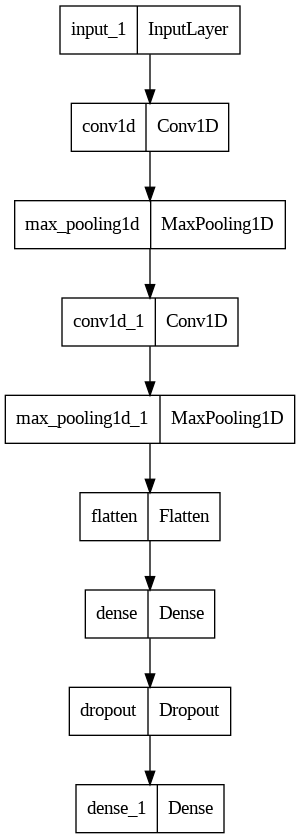

In [ ]:
plot_model(model1, to_file='model_plot1.png', show_layer_names=True)

In [ ]:
history1 = model1.fit(X_train, y_train,
                    batch_size=128, epochs=30, verbose=1,
                    validation_data=(X_val, y_val),
                    shuffle=True, callbacks=callbacks)

Epoch 1/30
83/83 [==============================] - 7s 55ms/step - loss: 1.4760 - accuracy: 0.4030 - val_loss: 1.1184 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 4s 49ms/step - loss: 1.0024 - accuracy: 0.6297 - val_loss: 0.8008 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - 5s 59ms/step - loss: 0.8243 - accuracy: 0.6918 - val_loss: 0.6881 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 4/30
83/83 [==============================] - 4s 44ms/step - loss: 0.7181 - accuracy: 0.7271 - val_loss: 0.6044 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 5/30
83/83 [==============================] - 2s 23ms/step - loss: 0.6530 - accuracy: 0.7472 - val_loss: 0.6057 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 6/30
83/83 [==============================] - 2s 20ms/step - loss: 0.6086 - accuracy: 0.7601 - val_loss: 0.5113 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 7/30
83/83 [==============================] - 2s 19ms/step - loss: 0.5

16/16 [==============================] - 0s 3ms/step - loss: 0.2802 - accuracy: 0.9340
Test accuracy 0.9340000152587891
Test loss 0.2802273631095886


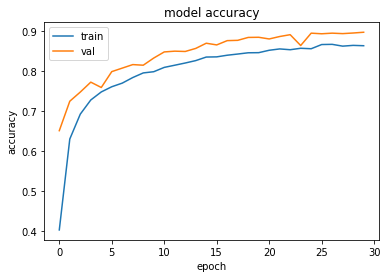

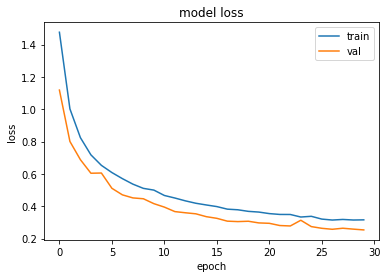

In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_accuracy(history1)
plot_loss(history1)

16/16 [==============================] - 0s 3ms/step


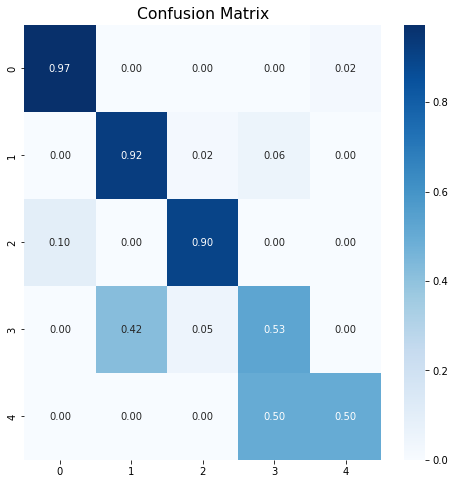

In [ ]:
plot_confusion_matrix(model1, X_test)

In [ ]:
y_pred = model1.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       292
         1.0       0.95      0.92      0.93       177
         2.0       0.60      0.90      0.72        10
         3.0       0.48      0.53      0.50        19
         4.0       0.14      0.50      0.22         2

    accuracy                           0.93       500
   macro avg       0.63      0.76      0.67       500
weighted avg       0.95      0.93      0.94       500



### Model 2: LSTM

The second model is a LSTM model, which has an input layer with a shape of (140,1), since we have data with 140 timesteps and one feature (140x1 array). The model consists of two LSTM layers, both followed a Dropout layer to prevent overfitting. After that there is a Dense layer and another Dropout layer. The final layer is a Dense output layer with 5 neurons (since we have 5 different classes) and a Softmax activation function.

Moreover, Adam was used as optimizer with a learning rate of 0.001 and sparse categorical crossentropy as loss function. The model also has two callbacks: a ReduceLROnPlateau callback to reduce the learning rate when the validation loss reaches a plateau and an EarlyStopping callback to stop the training when the validation loss has not improved after a certain number of epochs.

In [ ]:
layer_in = layers.Input(shape=(140,1)) 
layer = layers.LSTM(16, return_sequences=True)(layer_in)
layer = layers.Dropout(0.4)(layer)
layer = layers.LSTM(16, return_sequences=False)(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Dense(32, activation='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model2 = tf.keras.models.Model(layer_in, layer_out)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5,
                                           verbose=1)
             ]

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 140, 16)           1152      
                                                                 
 dropout_1 (Dropout)         (None, 140, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0   

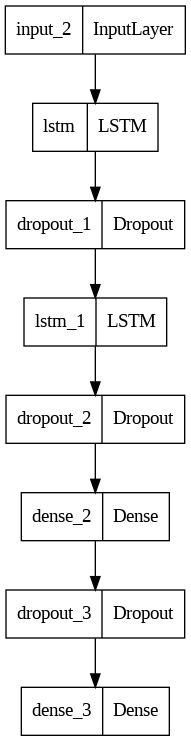

In [ ]:
plot_model(model2, to_file='model_plot2.png', show_layer_names=True)

In [ ]:
history2 = model2.fit(X_train, y_train,
                      batch_size=128, epochs=30, verbose=1,
                      validation_data=(X_val, y_val),
                      shuffle=True, callbacks=callbacks)

Epoch 1/30
83/83 [==============================] - 14s 123ms/step - loss: 1.5900 - accuracy: 0.2600 - val_loss: 1.4933 - val_accuracy: 0.3959 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 9s 109ms/step - loss: 1.2670 - accuracy: 0.4802 - val_loss: 1.0551 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - 11s 136ms/step - loss: 1.1114 - accuracy: 0.5454 - val_loss: 0.9761 - val_accuracy: 0.6517 - lr: 0.0010
Epoch 4/30
83/83 [==============================] - 10s 115ms/step - loss: 1.0315 - accuracy: 0.6068 - val_loss: 0.8654 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 5/30
83/83 [==============================] - 10s 119ms/step - loss: 0.9474 - accuracy: 0.6412 - val_loss: 0.7849 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 6/30
83/83 [==============================] - 10s 119ms/step - loss: 0.8963 - accuracy: 0.6702 - val_loss: 0.7832 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 7/30
83/83 [==============================] - 10s 120ms/ste

16/16 [==============================] - 0s 19ms/step - loss: 0.3708 - accuracy: 0.9080
Test accuracy 0.9079999923706055
Test loss 0.3708057701587677


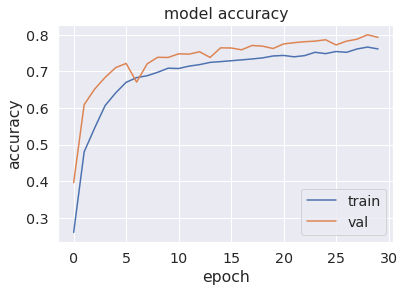

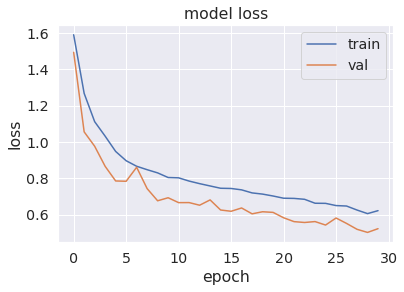

In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_accuracy(history2)
plot_loss(history2)

16/16 [==============================] - 1s 17ms/step


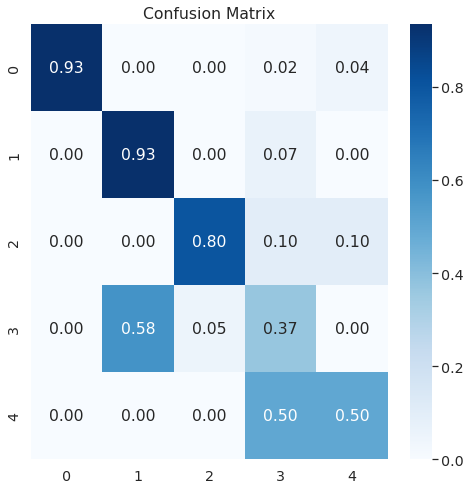

In [ ]:
plot_confusion_matrix(model2, X_test)

In [ ]:
y_pred = model2.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

16/16 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97       292
         1.0       0.94      0.93      0.93       177
         2.0       0.80      0.80      0.80        10
         3.0       0.27      0.37      0.31        19
         4.0       0.07      0.50      0.12         2

    accuracy                           0.91       500
   macro avg       0.61      0.71      0.63       500
weighted avg       0.94      0.91      0.92       500



### Model 3: Conv1D + LSTM

The third model is a Conv1D + LSTM model, which is a combination of the previous models (CNN and RNN). It has an input layer with a shape of (140,1), since we have data with 140 timesteps and one feature (140x1 array). The model consists of a Conv1D layer, followed a MaxPool1D layer with a pool size of 4. Next, the model has a LSTM layer with 16 units followed by a Dropout layer. Then there is Dense layer and another Dropout layer with a rate of 0.2. The final layer is a Dense output layer with 5 neurons (since we have 5 different classes) and a Softmax activation function.

Moreover, Adam was used as optimizer with a learning rate of 0.001 and sparse categorical crossentropy as loss function. The model also has two callbacks: a ReduceLROnPlateau callback to reduce the learning rate when the validation loss reaches a plateau and an EarlyStopping callback to stop the training when the validation loss has not improved after a certain number of epochs.

In [ ]:
layer_in = layers.Input(shape=(140,1))
layer = layers.Conv1D(filters=32, kernel_size=8, activation='relu')(layer_in)
layer = layers.MaxPool1D(pool_size=4)(layer)
layer = layers.LSTM(16, return_sequences=False)(layer)
layer = layers.Dropout(0.2)(layer)
layer = layers.Dense(32, activation='relu')(layer)
layer = layers.Dropout(0.2)(layer)
layer_out = layers.Dense(5, activation='softmax')(layer)

model3 = tf.keras.models.Model(layer_in, layer_out)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.1, 
                                               patience=3,
                                               ),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5,
                                           verbose=1)
             ]

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


In [ ]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 133, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                             

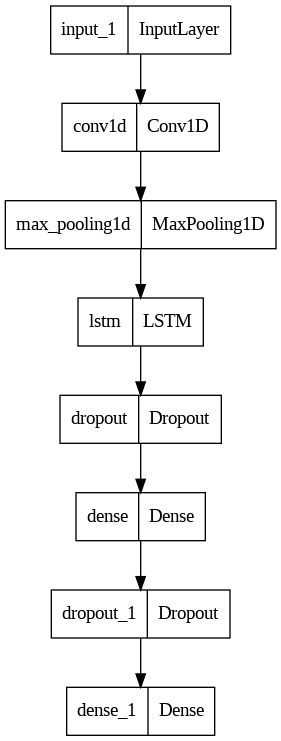

In [ ]:
plot_model(model3, to_file='model_plot3.png', show_layer_names=True)

In [ ]:
history3 = model3.fit(X_train, y_train,
                      batch_size=128, epochs=30, verbose=1,
                      validation_data=(X_val, y_val),
                      shuffle=True, callbacks=callbacks)

Epoch 1/30
83/83 [==============================] - 6s 39ms/step - loss: 1.5984 - accuracy: 0.2200 - val_loss: 1.5622 - val_accuracy: 0.2604 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 2s 25ms/step - loss: 1.4215 - accuracy: 0.4113 - val_loss: 1.1503 - val_accuracy: 0.5695 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - 2s 25ms/step - loss: 1.1275 - accuracy: 0.5619 - val_loss: 0.9968 - val_accuracy: 0.6368 - lr: 0.0010
Epoch 4/30
83/83 [==============================] - 2s 24ms/step - loss: 1.0254 - accuracy: 0.6155 - val_loss: 0.8905 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 5/30
83/83 [==============================] - 2s 25ms/step - loss: 0.9461 - accuracy: 0.6493 - val_loss: 0.8101 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 6/30
83/83 [==============================] - 3s 31ms/step - loss: 0.8938 - accuracy: 0.6688 - val_loss: 0.7779 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 7/30
83/83 [==============================] - 2s 27ms/step - loss: 0.8

16/16 [==============================] - 0s 5ms/step - loss: 0.3481 - accuracy: 0.9100
Test accuracy 0.9100000262260437
Test loss 0.34812137484550476


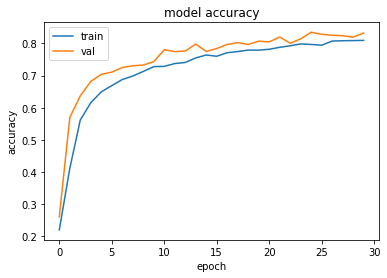

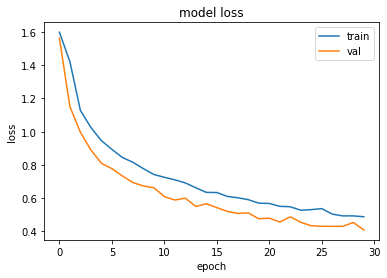

In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

plot_accuracy(history3)
plot_loss(history3)

16/16 [==============================] - 0s 5ms/step


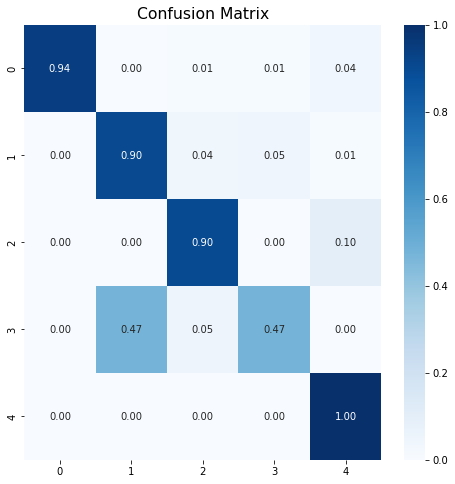

In [ ]:
plot_confusion_matrix(model3, X_test)

In [ ]:
y_pred = model3.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

16/16 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       292
         1.0       0.95      0.90      0.92       177
         2.0       0.45      0.90      0.60        10
         3.0       0.45      0.47      0.46        19
         4.0       0.12      1.00      0.22         2

    accuracy                           0.91       500
   macro avg       0.59      0.84      0.64       500
weighted avg       0.95      0.91      0.92       500



### Conclusions

As we can see, all the three models obtained similar results in the classification of the 5 different classes (the first one corresponding to a normal signal and the remaining ones corresponding to anomalous signals). Moreover, the precision and f1-score of the classes with low support (like classes 3-5), tend to be lower despite the imbalance handling.
The use of LSTM layers is particulary useful when dealing with sequences of data like ECG, since it captures the temporal dependencies and preserve the sequential structure of the input data. However, the effect is probably noticeable when dealing with longer and more complex sequences.